# Librerías

In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from eli5 import show_weights, show_prediction
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
from keras.layers import Masking

%matplotlib inline

# Datos

In [12]:
train = pd.read_csv('../data/week3/final_train_pw.csv')
test = pd.read_csv('../data/week3/final_test_pw.csv')

In [13]:
train.head()

,product_id,block_id,stock,std_stock,family_id,subfamily_id,size_id,color_id,position,category_id,...,N2,N3,N5,N6,N7,N8,N9,N10,N12,N13
0,310130,1726,1383,34.811328,0.007397,0.000575,7,1,3.0,3,...,19,59,14,12,9064,14,14,12,19,19
1,1178388,592,60,2.160247,0.048717,0.012075,4,1,19.0,1,...,595,1107,14,14,16499,14,307,184,14,592
2,1561460,1625,2373,55.438769,0.126496,0.023730,5,1,38.0,3,...,730,2435,14,14,12817,14,1720,571,17,730
3,1874414,1135,1686,20.463906,0.109919,0.015895,6,1,12.0,6,...,663,1439,14,14,8041,14,398,103,14,636
4,2436420,779,245,23.377339,0.026020,0.004415,5,1,NaN,0,...,223,453,14,14,12817,14,39,23,23,223


In [14]:
test.head()

,product_id,block_id,stock,std_stock,family_id,subfamily_id,size_id,color_id,position,category_id,...,N2,N3,N5,N6,N7,N8,N9,N10,N12,N13
0,151926,1969,1575,21.800597,0.126496,0.033008,5,1,68.0,2,...,1297,3347,5,5,12817,5,1866,638,5,1297
1,213413,1648,4501,39.691338,0.027765,0.002300,7,1,64.0,2,...,150,236,13,13,9064,13,59,46,13,150
2,310130,1726,2379,47.439462,0.007397,0.000575,7,1,49.0,1,...,19,59,14,12,9064,14,14,12,19,19
3,455200,1400,336,6.296997,0.049205,0.008595,3,1,47.0,2,...,271,531,7,7,10206,7,119,90,9,199
4,571044,1098,777,19.208555,0.099579,0.022151,3,2,173.0,4,...,304,1545,11,1,2349,11,624,44,1,194


In [15]:
drop_cols = ['sales', 'date_number', 'product_id', 'block_id']

X_train = train.loc[:,[c for c in train.columns if c not in drop_cols]]
y_train = train[['sales']]
X_test = test.loc[:,[c for c in train.columns if c not in drop_cols]]

Estandarización de las variables para modelos lineales y redes neuronales.

In [16]:
cols_ss = ['stock', 'std_stock', 'position', 'stock_lag1',
       'stock_lead1', 'std_stock_shift1', 'mean_stock_shift1',
       'min_stock_shift1', 'max_stock_shift1', 'median_stock_shift1',
       'stock_lag2', 'stock_lead2', 'std_stock_shift2', 'min_stock_shift2',
       'max_stock_shift2', 'median_stock_shift2', 'mean_stock_shift2',
       'pos_lag1', 'pos_lead1', 'std_pos_shift1', 'mean_pos_shift1',
       'min_pos_shift1', 'max_pos_shift1', 'median_pos_shift1', 'pos_lag2',
       'pos_lead2', 'std_pos_shift2', 'min_pos_shift2', 'max_pos_shift2',
       'median_pos_shift2', 'mean_pos_shift2', 'diff_stock_lead1',
       'diff_stock_lead2', 'diff_stock_lag1', 'diff_stock_lag2',
       'diff_pos_lead1', 'diff_pos_lead2', 'diff_pos_lag1', 'diff_pos_lag2',
       'std_stock_shift3', 'mean_stock_shift3', 'min_stock_shift3',
       'max_stock_shift3', 'median_stock_shift3', 'std_pos_shift3',
       'mean_pos_shift3', 'min_pos_shift3', 'max_pos_shift3',
       'median_pos_shift3', 'ratio_position',
       'N1', 'N2', 'N3', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N12', 'N13']

In [17]:
# ss = StandardScaler()
# ss.fit(X_train[cols_ss])
# X_train[cols_ss] = ss.transform(X_train[cols_ss])
# X_test[cols_ss] = ss.transform(X_test[cols_ss])

In [18]:
# X_test.head()

In [19]:
train_ids = X_train.index
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Matrix de correlación

In [20]:
# corr = X_train.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)

# Selección de variables

In [21]:
# from sklearn.ensemble import RandomForestClassifier

In [22]:
# X_train_sample = X_train.fillna(-1).sample(frac=0.1)
# X_fit, X_val, y_fit, y_val = train_test_split(X_train_sample,
#                                               y_train.iloc[X_train_sample.index.values],
#                                               test_size=0.25,
#                                               random_state=42)

In [23]:
# params = {
#     'n_estimators': 500,
#     'criterion': 'entropy',
#     'max_depth': 10,
#     'random_state': 42,
#     'n_jobs': 8,
#     'verbose': 0,
#     'min_samples_leaf': 2,
    
# }

# rf = RandomForestClassifier(**params)

In [24]:
# rf_refit = rf.fit(X_fit, y_fit)

In [25]:
# perm = PermutationImportance(rf_refit).fit(X_val, y_val)
# show_weights(perm, feature_names=X_val.columns.tolist(), top=X_val.shape[1])

In [26]:
# X = X.fillna(-1)

# LightGBM

In [27]:
model_name = 'lgbm'

params = {'max_depth':7,
          'metric':'mae',
          'max_delta_step': 0.2,
          'n_estimators':50000,
          'learning_rate':0.1,
          'colsample_bytree':0.6,
          'objective':'regression',
          'n_jobs':8,
          'seed':42,
          'lambda_l1':0,
          'lambda_l2':0,
         }

lgb_model = lgb.LGBMRegressor(**params)

In [28]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    lgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=1000,
                  early_stopping_rounds=50)

    ft_importances += lgb_model.feature_importances_

    be += np.expm1(lgb_model.best_score_['valid_0']['l1'])
    y_preds = np.expm1(lgb_model.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]
    
    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_lightgbm_pw': full_preds})
pr.to_csv('../predictions/week3/preds_lightgbm_pw.csv')

# print('IMPORTANCIA DE LAS VARIABLES:\n')
# imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
# df_imp_sort = imp.sort_values('importance', ascending=False)
# df_imp_sort

--- Fold k 1:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.464639
[2000]	valid_0's l1: 0.452525
[3000]	valid_0's l1: 0.447508
[4000]	valid_0's l1: 0.444495
Early stopping, best iteration is:
[4131]	valid_0's l1: 0.44403
--- Fold k 2:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.457404
[2000]	valid_0's l1: 0.444671
[3000]	valid_0's l1: 0.439639
Early stopping, best iteration is:
[2976]	valid_0's l1: 0.439579
--- Fold k 3:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.459256
[2000]	valid_0's l1: 0.446611
[3000]	valid_0's l1: 0.441184
Early stopping, best iteration is:
[3720]	valid_0's l1: 0.438749
--- Fold k 4:
Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's l1: 0.474915
[2000]	valid_0's l1: 0.460852
Early stopping, best iteration is:
[2109]	valid_0's l1: 0.459947
--- Fold k 5:
Training until validation scores don't improve for 50 rounds.
[

# XGBoost

In [29]:
params = {'max_depth': 7,
          'metric':'mae',
          'n_estimators': 5000,
          'eta': 0.1,
          'colsample_bytree':0.6,
          'nthread':8,
          'seed':42,
          'objective':'reg:linear',
         }

xgb_model = xgb.XGBRegressor(**params)

In [30]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    xgb_model.fit(X_fit,
                  y_fit,
                  eval_set=[(X_val, y_val)],
                  verbose=100,
                  early_stopping_rounds=10,
                  eval_metric='mae')

    ft_importances += xgb_model.feature_importances_

    be += np.expm1(xgb_model.best_score)
    y_preds = np.expm1(xgb_model.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]

    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_xgboost_pw': full_preds})
pr.to_csv('../predictions/week3/preds_xgboost_pw.csv')

# print('IMPORTANCIA DE LAS VARIABLES:\n')
# imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
# df_imp_sort = imp.sort_values('importance', ascending=False)
# df_imp_sort

--- Fold k 1:
[0]	validation_0-mae:2.50366
Will train until validation_0-mae hasn't improved in 10 rounds.
[100]	validation_0-mae:0.491255
[200]	validation_0-mae:0.473697
[300]	validation_0-mae:0.466382
[400]	validation_0-mae:0.462095
[500]	validation_0-mae:0.459078
Stopping. Best iteration:
[571]	validation_0-mae:0.457553

--- Fold k 2:
[0]	validation_0-mae:2.40069
Will train until validation_0-mae hasn't improved in 10 rounds.
[100]	validation_0-mae:0.482267
[200]	validation_0-mae:0.464821
[300]	validation_0-mae:0.456044
[400]	validation_0-mae:0.451024
[500]	validation_0-mae:0.448104
[600]	validation_0-mae:0.445398
[700]	validation_0-mae:0.443579
Stopping. Best iteration:
[716]	validation_0-mae:0.443442

--- Fold k 3:
[0]	validation_0-mae:2.42462
Will train until validation_0-mae hasn't improved in 10 rounds.
[100]	validation_0-mae:0.482849
[200]	validation_0-mae:0.467036
[300]	validation_0-mae:0.458653
[400]	validation_0-mae:0.453428
[500]	validation_0-mae:0.449812
[600]	validation_

# CatBoost

In [31]:
params = {
    'depth':7,
    'iterations':5000,
    'eval_metric':'MAE',
    'random_seed':42,
    'early_stopping_rounds':[5],
    'learning_rate':0.1,
    'thread_count':8,
    'boosting_type':'Plain',
    'bootstrap_type':'Bernoulli',
    'colsample_bylevel':0.6
}

model_cb = CatBoostRegressor(**params)

In [32]:
counter = 1
be = 0
ft_importances = np.zeros(X_train.shape[1])
full_preds = np.zeros(X_test.shape[0])

for train_index, test_index in skf.split(train_ids, y_train):
    print('--- Fold k {}:'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    y_val = np.log1p(y_val)
    y_fit = np.log1p(y_fit)

    model_cb.fit(X_fit,
                 y_fit,
                 eval_set=[(X_val, y_val)],
                 verbose=200,
#                  cat_features=cat_ft_id,
                 early_stopping_rounds=10)

    ft_importances += model_cb.feature_importances_

    be += np.expm1(model_cb.best_score_['validation_0']['MAE'])
    y_preds = np.expm1(model_cb.predict(X_test))
    full_preds += y_preds
    y_preds = [int(round(x)) for x in y_preds]

    counter += 1
    

full_preds = full_preds/k
full_preds = [int(round(x)) for x in full_preds]

pr = pd.DataFrame({'predicciones_catboost_pw': full_preds})
pr.to_csv('../predictions/week3/preds_catboost_pw.csv')

# print('IMPORTANCIA DE LAS VARIABLES:\n')
# imp = pd.DataFrame({'feature': X_train.columns, 'importance': ft_importances/k})
# df_imp_sort = imp.sort_values('importance', ascending=False)
# df_imp_sort

--- Fold k 1:
0:	learn: 2.7891680	test: 2.8501207	best: 2.8501207 (0)	total: 61.2ms	remaining: 5m 5s
200:	learn: 0.4990715	test: 0.5233385	best: 0.5233385 (200)	total: 2.2s	remaining: 52.6s
400:	learn: 0.4574507	test: 0.4955384	best: 0.4955384 (400)	total: 4.33s	remaining: 49.7s
600:	learn: 0.4315255	test: 0.4819095	best: 0.4819095 (600)	total: 6.47s	remaining: 47.4s
800:	learn: 0.4120457	test: 0.4743661	best: 0.4743661 (800)	total: 8.71s	remaining: 45.6s
1000:	learn: 0.3957493	test: 0.4688761	best: 0.4688761 (1000)	total: 11.1s	remaining: 44.4s
1200:	learn: 0.3813739	test: 0.4648451	best: 0.4648240 (1199)	total: 13.5s	remaining: 42.8s
1400:	learn: 0.3685590	test: 0.4618166	best: 0.4618069 (1398)	total: 16.2s	remaining: 41.6s
1600:	learn: 0.3565484	test: 0.4591006	best: 0.4591006 (1600)	total: 18.4s	remaining: 39s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.4564770715
bestIteration = 1772

Shrink model to first 1773 iterations.
--- Fold k 2:
0:	learn: 2.8158112	

# Keras

In [54]:
X_train_sample = X_train.fillna(-1)#.sample(frac=0.1)
X_fit, X_val, y_fit, y_val = train_test_split(X_train_sample,
                                              y_train.iloc[X_train_sample.index.values],
                                              test_size=0.25,
                                              random_state=42)

y_val = np.log1p(y_val)
y_fit = np.log1p(y_fit)

In [125]:
callbacks = [EarlyStopping(monitor='val_loss',
                           min_delta=0.0,
                           patience=3,
                           verbose=1,
                           mode='min',
                           restore_best_weights=True)]

In [126]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1024, kernel_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.add(Masking(mask_value=-1))
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [127]:
estimator = KerasRegressor(build_fn=create_baseline,
                           epochs=100,
                           batch_size=1024,
                           verbose=1,
                           callbacks=callbacks,
                           validation_data=(X_val, y_val))

In [128]:
model = create_baseline()

In [129]:
history = estimator.fit(X_fit, y_fit)

Train on 53986 samples, validate on 12954 samples
Epoch 1/100
53986/53986 [==============================] - 3s 57us/step - loss: 71.5701 - val_loss: 40.5570
Epoch 2/100
53986/53986 [==============================] - 2s 41us/step - loss: 56.9466 - val_loss: 39.2343
Epoch 3/100
53986/53986 [==============================] - 2s 41us/step - loss: 54.9822 - val_loss: 39.2244
Epoch 4/100
53986/53986 [==============================] - 2s 42us/step - loss: 53.6224 - val_loss: 38.5947
Epoch 5/100
53986/53986 [==============================] - 2s 42us/step - loss: 51.8336 - val_loss: 35.3132
Epoch 6/100
53986/53986 [==============================] - 2s 41us/step - loss: 50.3344 - val_loss: 35.2626
Epoch 7/100
53986/53986 [==============================] - 2s 42us/step - loss: 49.2566 - val_loss: 33.7970
Epoch 8/100
53986/53986 [==============================] - 2s 42us/step - loss: 49.0929 - val_loss: 35.3010
Epoch 9/100
53986/53986 [==============================] - 2s 43us/step - loss: 47.899

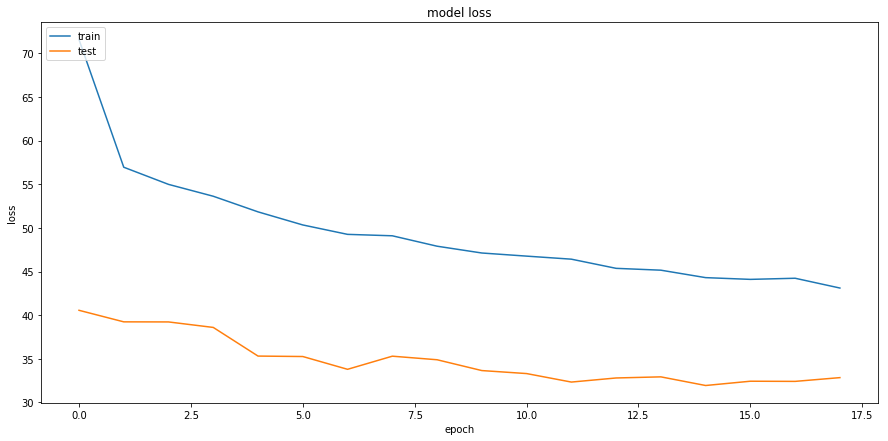

In [130]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
keras_preds = estimator.predict(X_test.fillna(-1))

8892/8892 [==============================] - 0s 42us/step


In [132]:
np.expm1(keras_preds)[:20]

array([2.6985578e+22, 6.4428597e+23, 8.6390270e+11, 8.6514801e+01,
       2.7918719e+26,           inf,           inf, 8.3036050e-02,
       1.2666060e+06, 8.2322948e+34, 4.8008733e+00, 4.0634163e+09,
       1.2145674e+02, 1.6532171e+00,           inf, 2.4927830e+32,
       2.1460220e+25, 1.0394682e+07, 2.5452344e+05, 3.0771423e+24],
      dtype=float32)

In [104]:
from sklearn.linear_model import Lasso, Ridge

In [133]:
lasso = Lasso()
ridge = Ridge(alpha=100,
              fit_intercept=True,
              normalize=False,
              copy_X=True,
              max_iter=1e6,
              tol=0.01,
              random_state=42)

In [134]:
counter = 1
be = 0
for train_index, test_index in skf.split(train_ids, y_train):
    print('Fold k {}\n'.format(counter))

    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_fit = X_fit.fillna(-1)
    X_val = X_val.fillna(-1)
    
#     y_val = np.log1p(y_val)
#     y_fit = np.log1p(y_fit)
    
    ridge.fit(X_fit, y_fit)
    
    print('Score en el test:',mean_absolute_error(ridge.predict(X_val), y_val),'ventas')
#     print('Score en el test:',mean_absolute_error(np.expm1(lasso.predict(X_test.fillna(-1))), y_test),'ventas')
    
    counter += 1
    
    
# print('\n\nBEST SCORE MEAN:', be / k,'SALES :)')

Fold k 1

Score en el test: 64.88086937583938 ventas
Fold k 2

Score en el test: 54.13480765738701 ventas
Fold k 3

Score en el test: 57.697222867256 ventas
Fold k 4

Score en el test: 95.66856823488475 ventas
Fold k 5

Score en el test: 54.505076034070875 ventas


In [136]:
from sklearn.model_selection import TimeSeriesSplit

In [143]:
tscv = TimeSeriesSplit(n_splits=63)

In [144]:
counter = 1
be = 0
for train_index, test_index in tscv.split(X_train):
    X_fit, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_fit, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
    
    X_fit = X_fit.fillna(-1)
    X_val = X_val.fillna(-1)
    
#     y_val = np.log1p(y_val)
#     y_fit = np.log1p(y_fit)
    
    
    ridge.fit(X_fit,
                  y_fit,
#                   eval_set=[(X_val, y_val)],
#                   verbose=1000,
#                   early_stopping_rounds=20
             )
    
    print('Score en el test:',mean_absolute_error(ridge.predict(X_val), y_val),'ventas')

#     be += np.expm1(lgb_model.best_score_['valid_0']['l1'])
#     be += lgb_model.best_score_['valid_0']['l1']
    
#     print('Score en el test:',mean_absolute_error(lgb_model.predict(X_test), y_test),'ventas')
#     print('Score en el test:',mean_absolute_error(np.expm1(lgb_model.predict(X_test)), y_test),'ventas')
    
    counter += 1

Score en el test: 14.756823797072453 ventas
Score en el test: 14.100715922865659 ventas
Score en el test: 12.151307647028101 ventas
Score en el test: 51.86876752206717 ventas
Score en el test: 71.48256121213558 ventas
Score en el test: 71.92217457062922 ventas
Score en el test: 68.28141522284636 ventas
Score en el test: 70.27419173579888 ventas
Score en el test: 68.17364411398036 ventas
Score en el test: 68.03255886397835 ventas
Score en el test: 67.67764600238846 ventas
Score en el test: 67.92744267608478 ventas
Score en el test: 60.29241413900714 ventas
Score en el test: 73.54090753222067 ventas
Score en el test: 98.75496060857435 ventas
Score en el test: 101.1358736415784 ventas
Score en el test: 94.34493406037016 ventas
Score en el test: 89.109853582185 ventas
Score en el test: 94.87292021432982 ventas
Score en el test: 101.50598193500386 ventas
Score en el test: 83.5619960969 ventas
Score en el test: 82.39001244804034 ventas
Score en el test: 79.99393026544735 ventas
Score en el t